## 1. Setup
Install the updated requirements (scipy, pyproj, matplotlib, folium) if you haven't already.

In [84]:
from __future__ import annotations

import json
from dataclasses import dataclass
from pathlib import Path
from typing import Tuple

import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from matplotlib import cm, colors
from pyproj import Transformer
import sqlalchemy as sa

load_dotenv(Path('..') / '.env')

BASE_DIR = Path('..').resolve()
PROCESSED_DIR = BASE_DIR / 'data' / 'processed'
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print('Base dir:', BASE_DIR)

Base dir: /home/zerotwo/iot/Siata-Contamination-Viewer


In [85]:
# Database connection setup
import os
DATABASE_URL = os.getenv('DATABASE_URL')
if not DATABASE_URL:
    raise ValueError("DATABASE_URL environment variable not set")

engine = sa.create_engine(DATABASE_URL)
print("Connected to database")

# Get the latest timestamp
with engine.connect() as conn:
    result = conn.execute(sa.text("SELECT MAX(ts) as latest_ts FROM clean_measurements"))
    latest_row = result.fetchone()
    if latest_row and latest_row[0]:
        latest_ts = pd.to_datetime(latest_row[0], utc=True)
        print(f"Latest measurement timestamp: {latest_ts}")
    else:
        print("No measurements found in database")
        latest_ts = pd.Timestamp.now(tz='UTC')

Connected to database
Latest measurement timestamp: 2025-09-30 04:50:06+00:00
Latest measurement timestamp: 2025-09-30 04:50:06+00:00


## 2. Fetch a snapshot from `clean_measurements`
Choose a timestamp (UTC) to grid. By default we grab the most recent one.

In [86]:
from datetime import timedelta

def ensure_utc(value) -> pd.Timestamp:
    ts = pd.Timestamp(value)
    if ts.tzinfo is None:
        return ts.tz_localize('UTC')
    return ts.tz_convert('UTC')


def load_clean_snapshot(target_ts=None, window_minutes=5):
    ts = ensure_utc(target_ts if target_ts is not None else latest_ts)
    start = ts - pd.Timedelta(minutes=window_minutes)
    end = ts + pd.Timedelta(minutes=window_minutes)
    query = sa.text(
        'SELECT cm.sensor_id, cm.ts, cm.value_mm, cm.imputation_method, '
        's.lat, s.lon '
        'FROM clean_measurements cm '
        'JOIN sensors s ON s.id = cm.sensor_id '
        'WHERE cm.ts BETWEEN :start AND :end'
    )
    df = pd.read_sql(query, engine, params={'start': start, 'end': end})
    df['ts'] = pd.to_datetime(df['ts'], utc=True)
    return df.sort_values('sensor_id')

snapshot_df = load_clean_snapshot()
print(snapshot_df.shape)
snapshot_df.head()


(226, 6)


,sensor_id,ts,value_mm,imputation_method,lat,lon
0,pluvio_1,2025-09-30 04:50:06+00:00,0.0,None,6.222600,-75.628200
1,pluvio_10,2025-09-30 04:50:06+00:00,0.0,global_median,6.315334,-75.657627
2,pluvio_1019,2025-09-30 04:50:06+00:00,0.0,None,6.259215,-75.588640
3,pluvio_105,2025-09-30 04:50:06+00:00,0.0,None,6.096280,-75.635360
4,pluvio_11,2025-09-30 04:50:06+00:00,0.0,None,6.273131,-75.651637


In [87]:
from datetime import timedelta

def ensure_utc(value) -> pd.Timestamp:
    ts = pd.Timestamp(value)
    if ts.tzinfo is None:
        return ts.tz_localize('UTC')
    return ts.tz_convert('UTC')


def load_clean_snapshot(target_ts=None, window_minutes=5):
    ts = ensure_utc(target_ts if target_ts is not None else latest_ts)
    start = ts - pd.Timedelta(minutes=window_minutes)
    end = ts + pd.Timedelta(minutes=window_minutes)
    query = sa.text(
        'SELECT cm.sensor_id, cm.ts, cm.value_mm, cm.imputation_method, '
        's.lat, s.lon '
        'FROM clean_measurements cm '
        'JOIN sensors s ON s.id = cm.sensor_id '
        'WHERE cm.ts BETWEEN :start AND :end'
    )
    df = pd.read_sql(query, engine, params={'start': start, 'end': end})
    df['ts'] = pd.to_datetime(df['ts'], utc=True)
    return df.sort_values('sensor_id')

snapshot_df = load_clean_snapshot()
print(snapshot_df.shape)
snapshot_df.head()


(226, 6)


,sensor_id,ts,value_mm,imputation_method,lat,lon
0,pluvio_1,2025-09-30 04:50:06+00:00,0.0,None,6.222600,-75.628200
1,pluvio_10,2025-09-30 04:50:06+00:00,0.0,global_median,6.315334,-75.657627
2,pluvio_1019,2025-09-30 04:50:06+00:00,0.0,None,6.259215,-75.588640
3,pluvio_105,2025-09-30 04:50:06+00:00,0.0,None,6.096280,-75.635360
4,pluvio_11,2025-09-30 04:50:06+00:00,0.0,None,6.273131,-75.651637


high_mean_row = pd.read_sql(
    sa.text('''
        SELECT ts,
               AVG(value_mm) AS mean_mm
        FROM clean_measurements
        GROUP BY ts
        ORDER BY mean_mm DESC
        LIMIT 1
    '''),
    engine,
)

mean_ts = ensure_utc(high_mean_row.at[0, 'ts'])
mean_value = high_mean_row.at[0, 'mean_mm']

print('Timestamp with highest mean precipitation (UTC):', mean_ts)
print('Mean precipitation at that time:', round(mean_value, 2), 'mm')

high_mean_snapshot = load_clean_snapshot(target_ts=mean_ts, window_minutes=5)
print('Sensors in window:', len(high_mean_snapshot))
high_mean_snapshot[['sensor_id', 'value_mm']].head()

high_mean_row = pd.read_sql(
    sa.text('''
        SELECT ts,
               AVG(value_mm) AS mean_mm
        FROM clean_measurements
        GROUP BY ts
        ORDER BY mean_mm DESC
        LIMIT 1
    '''),
    engine,
)

mean_ts = ensure_utc(high_mean_row.at[0, 'ts'])
mean_value = high_mean_row.at[0, 'mean_mm']

print('Timestamp with highest mean precipitation (UTC):', mean_ts)
print('Mean precipitation at that time:', round(mean_value, 2), 'mm')

high_mean_snapshot = load_clean_snapshot(target_ts=mean_ts, window_minutes=5)
print('Sensors in window:', len(high_mean_snapshot))
high_mean_snapshot[['sensor_id', 'value_mm']].head()

In [ ]:
high_mean_row = pd.read_sql(
    sa.text('''
        SELECT ts AT TIME ZONE 'UTC' AS ts_utc,
               AVG(value_mm) AS mean_mm
        FROM clean_measurements
        GROUP BY ts
        ORDER BY mean_mm DESC
        LIMIT 1
    '''),
    engine,
)

mean_ts = pd.to_datetime(high_mean_row.at[0, 'ts_utc'], utc=True)
mean_value = high_mean_row.at[0, 'mean_mm']

print('Timestamp with highest mean precipitation (UTC):', mean_ts)
print('Mean precipitation at that time:', round(mean_value, 2), 'mm')

high_mean_snapshot = load_clean_snapshot(target_ts=mean_ts, window_minutes=5)
print('Sensors in window:', len(high_mean_snapshot))
high_mean_snapshot[['sensor_id', 'value_mm']].head()

Timestamp with highest median precipitation (UTC): 2022-06-25 22:35:00+00:00
Median precipitation at that time: 0.21 mm
Sensors in window: 143
Sensors in window: 143


,sensor_id,value_mm
0,vaisala_105,0.12
104,vaisala_105,0.28
39,vaisala_105,0.24
26,vaisala_105,0.18
65,vaisala_105,0.21


In [89]:
snapshot_df = high_median_snapshot.copy()
print('Using high-median snapshot:', snapshot_df['ts'].max())


Using high-median snapshot: 2022-06-25 22:40:00+00:00


In [90]:
transformer_to_3857 = Transformer.from_crs('EPSG:4326', 'EPSG:3857', always_xy=True)
transformer_to_wgs84 = Transformer.from_crs('EPSG:3857', 'EPSG:4326', always_xy=True)

snapshot_df['x'], snapshot_df['y'] = transformer_to_3857.transform(
    snapshot_df['lon'].to_numpy(),
    snapshot_df['lat'].to_numpy()
)

bbox_padding = 2000  # metres
res_m = 500

min_x = snapshot_df['x'].min() - bbox_padding
max_x = snapshot_df['x'].max() + bbox_padding
min_y = snapshot_df['y'].min() - bbox_padding
max_y = snapshot_df['y'].max() + bbox_padding

nx = int(np.ceil((max_x - min_x) / res_m)) + 1
ny = int(np.ceil((max_y - min_y) / res_m)) + 1

x_grid = np.linspace(min_x, max_x, nx)
y_grid = np.linspace(min_y, max_y, ny)

xx, yy = np.meshgrid(x_grid, y_grid)

print('Grid shape:', yy.shape, 'resolution (m):', res_m)


Grid shape: (85, 80) resolution (m): 500


### Seed the grid with nearest sensor values

In [91]:
seed_grid = np.full((ny, nx), np.nan, dtype=float)
mask = np.zeros_like(seed_grid, dtype=bool)

sensor_values = snapshot_df['value_mm'].to_numpy(dtype=float)
xi = ((snapshot_df['x'] - min_x) / res_m).round().astype(int)
yi = ((snapshot_df['y'] - min_y) / res_m).round().astype(int)

for i in range(len(snapshot_df)):
    gx = np.clip(xi[i], 0, nx - 1)
    gy = np.clip(yi[i], 0, ny - 1)
    if mask[gy, gx]:
        seed_grid[gy, gx] = np.nanmean([seed_grid[gy, gx], sensor_values[i]])
    else:
        seed_grid[gy, gx] = sensor_values[i]
        mask[gy, gx] = True

np.count_nonzero(mask), seed_grid.shape


(np.int64(13), (85, 80))

## 4. Lanczos-4 interpolation

In [92]:
from scipy.interpolate import griddata

# Prepare points and values for interpolation
points = np.column_stack((snapshot_df['x'], snapshot_df['y']))
values = snapshot_df['value_mm'].to_numpy(dtype=float)

# Flatten grid for interpolation
grid_points = np.column_stack((xx.ravel(), yy.ravel()))

# Perform quadratic (cubic) interpolation
quad_grid = griddata(points, values, grid_points, method='cubic')
quad_grid = quad_grid.reshape(xx.shape)

np.sum(~np.isnan(quad_grid))

np.int64(1898)

### 4.1 Fill remaining gaps via nearest neighbour

In [93]:
np.sum(np.isnan(lanczos_grid))

np.int64(6345)

## 5. Visualise grid and contours

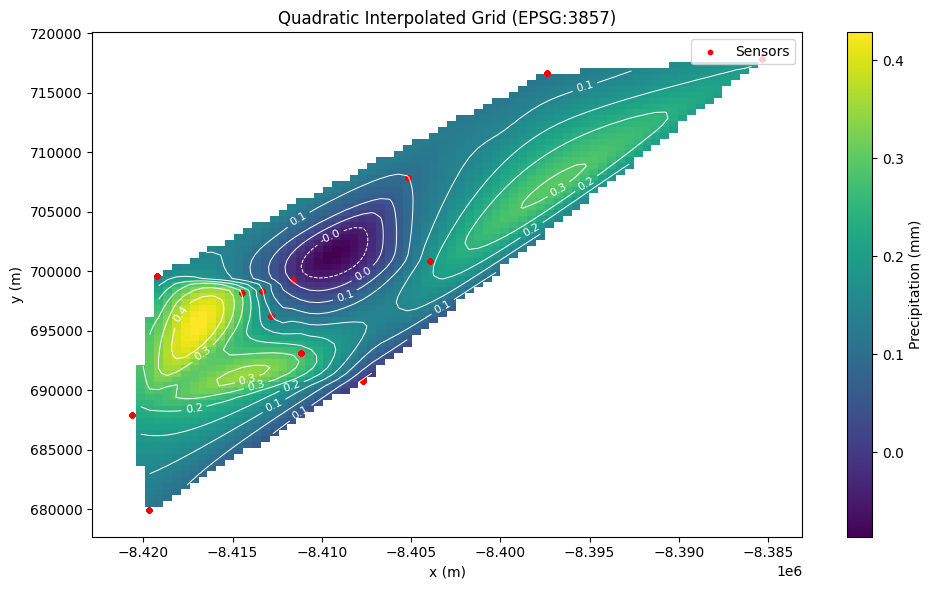

In [94]:
levels = np.linspace(np.nanmin(quad_grid), np.nanmax(quad_grid), 12)
fig, ax = plt.subplots(figsize=(10, 6))
mesh = ax.pcolormesh(x_grid, y_grid, quad_grid, cmap='viridis', shading='auto')
contours = ax.contour(x_grid, y_grid, quad_grid, levels=levels, colors='white', linewidths=0.7)
ax.clabel(contours, inline=True, fontsize=8, fmt='%.1f')
ax.scatter(snapshot_df['x'], snapshot_df['y'], c='red', s=10, label='Sensors')
ax.set_title('Quadratic Interpolated Grid (EPSG:3857)')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.legend(loc='upper right')
fig.colorbar(mesh, ax=ax, label='Precipitation (mm)')
plt.tight_layout()

## 6. Prepare artifacts (npz + metadata)

In [95]:
grid_metadata = {
    'timestamp': snapshot_df['ts'].max().isoformat(),
    'res_m': res_m,
    'bbox_3857': [float(min_x), float(min_y), float(max_x), float(max_y)],
}

# Convert bbox to WGS84 (min/max)
west, north = transformer_to_wgs84.transform(min_x, max_y)
east, south = transformer_to_wgs84.transform(max_x, min_y)
grid_metadata['bbox_wgs84'] = [west, south, east, north]

grid_npz_path = PROCESSED_DIR / f"grid_{snapshot_df['ts'].max().strftime('%Y%m%dT%H%M%SZ')}.npz"
np.savez_compressed(
    grid_npz_path,
    data=quad_grid.astype(np.float32),
    x=x_grid.astype(np.float64),
    y=y_grid.astype(np.float64),
    metadata=json.dumps(grid_metadata),
)

print('Saved grid to', grid_npz_path)
print('Metadata:', grid_metadata)

Saved grid to /home/zerotwo/iot/Siata-Contamination-Viewer/data/processed/grid_20220625T224000Z.npz
Metadata: {'timestamp': '2022-06-25T22:40:00+00:00', 'res_m': 500, 'bbox_3857': [-8422629.297668228, 677918.8913575178, -8383323.875885177, 719846.0725421285], 'bbox_wgs84': [-75.66176630568239, 6.078414999455299, -75.3086796943176, 6.4528027992725665]}


## 7. Interactive map preview (Folium)

/tmp/ipykernel_230255/3712365477.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  rgba = cm.get_cmap('viridis')(norm(quad_grid))



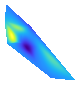

In [96]:
norm = colors.Normalize(vmin=np.nanmin(quad_grid), vmax=np.nanmax(quad_grid))
rgba = cm.get_cmap('viridis')(norm(quad_grid))
rgba[..., 3] = np.where(np.isnan(quad_grid), 0.0, 0.75)

west, north = transformer_to_wgs84.transform(min_x, max_y)
east, south = transformer_to_wgs84.transform(max_x, min_y)
bounds = [[south, west], [north, east]]

center_lat = snapshot_df['lat'].mean()
center_lon = snapshot_df['lon'].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=11, tiles='CartoDB positron')
folium.raster_layers.ImageOverlay(
    image=rgba,
    bounds=bounds,
    opacity=0.7,
    origin='upper',
    name='Interpolated Grid',
).add_to(m)

for _, row in snapshot_df.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=3,
        color='red',
        fill=True,
        fill_opacity=0.9,
        popup=f"{row['sensor_id']}<br>value: {row['value_mm']:.2f} mm",
    ).add_to(m)

folium.LayerControl().add_to(m)

m

/tmp/ipykernel_230255/4233132093.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  rgba = cm.get_cmap('viridis')(norm(quad_grid))



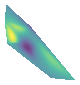

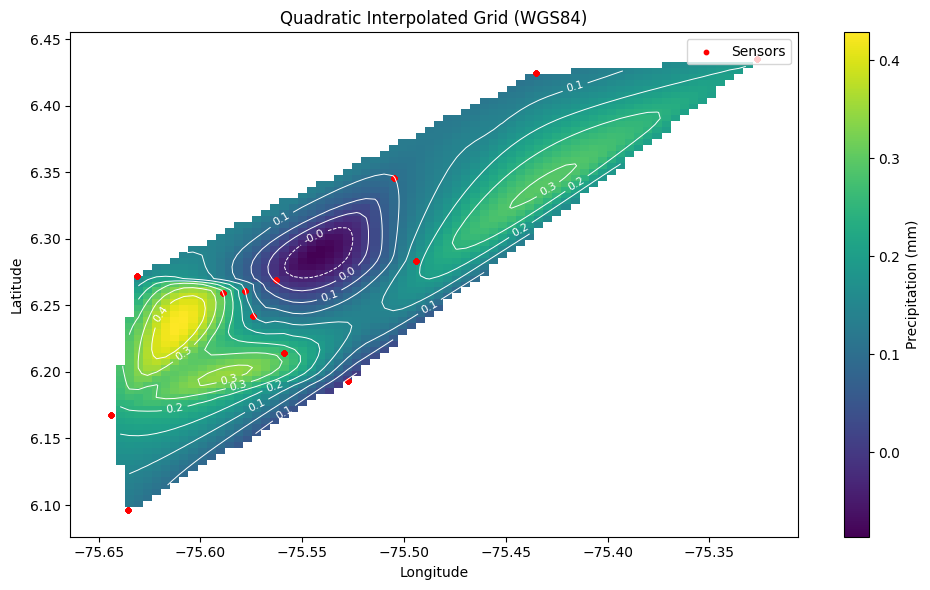

In [97]:
# Reproject grid coordinates from EPSG:3857 to WGS84 (lon/lat)
# transformer.transform expects (x, y) -> (x2, y2) when always_xy=True
lon_grid, lat_grid = transformer_to_wgs84.transform(xx, yy)

# Visualize the reprojected grid using matplotlib (lon, lat axes)
levels = np.linspace(np.nanmin(quad_grid), np.nanmax(quad_grid), 12)
fig, ax = plt.subplots(figsize=(10, 6))
mesh = ax.pcolormesh(lon_grid, lat_grid, quad_grid, cmap='viridis', shading='auto')
contours = ax.contour(lon_grid, lat_grid, quad_grid, levels=levels, colors='white', linewidths=0.7)
ax.clabel(contours, inline=True, fontsize=8, fmt='%.1f')
ax.scatter(snapshot_df['lon'], snapshot_df['lat'], c='red', s=10, label='Sensors')
ax.set_title('Quadratic Interpolated Grid (WGS84)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend(loc='upper right')
fig.colorbar(mesh, ax=ax, label='Precipitation (mm)')
plt.tight_layout()

# For Folium, create RGBA image and set alpha mask BEFORE flipping so it aligns correctly
norm = colors.Normalize(vmin=np.nanmin(quad_grid), vmax=np.nanmax(quad_grid))
rgba = cm.get_cmap('viridis')(norm(quad_grid))
alpha_mask = np.where(np.isnan(quad_grid), 0.0, 0.75)
rgba[..., 3] = alpha_mask
# Now flip vertically to match image coordinate expectations
rgba_for_overlay = np.flipud(rgba)

# Convert to uint8 0-255 (PIL/fiona expect uint8 images) to preserve alpha
rgba_uint8 = (np.clip(rgba_for_overlay, 0.0, 1.0) * 255).astype(np.uint8)

west, north = transformer_to_wgs84.transform(min_x, max_y)
east, south = transformer_to_wgs84.transform(max_x, min_y)
bounds = [[south, west], [north, east]]

center_lat = snapshot_df['lat'].mean()
center_lon = snapshot_df['lon'].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=11, tiles='CartoDB positron')
folium.raster_layers.ImageOverlay(
    image=rgba_uint8,
    bounds=bounds,
    opacity=1.0,
    origin='lower',
    name='Interpolated Grid',
).add_to(m)

for _, row in snapshot_df.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=3,
        color='red',
        fill=True,
        fill_opacity=0.9,
        popup=f"{row['sensor_id']}<br>value: {row['value_mm']:.2f} mm",
    ).add_to(m)

folium.LayerControl().add_to(m)

m